In [76]:
import numpy as np
import sys
import os
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from tools.data_helper import *
from tools.plot_helper import *
from tools.parameters import *

plt.rcParams['font.family'] = 'Arial'

# 获取到文件的绝对路径，并将其父目录添加到 sys.path
sys.path.append(os.path.abspath('../../../luto'))

# 导入 settings.py
import settings

def filter_dfs_by_substring(group_dict, substring):
    """
    根据主键名称筛选包含指定子字符串的 DataFrame。

    :param group_dict: 包含多个 DataFrame 的字典。
    :param substring: 用于匹配的主键子字符串。如果为 "*"，使用所有 DataFrame。
                      如果为列表，则匹配列表中的所有子字符串。
    :return: 筛选后的 DataFrame 字典。
    """
    if substring == "*":
        return group_dict

    if isinstance(substring, list):
        return {name: df for name, df in group_dict.items() if any(sub in name for sub in substring)}

    return {name: df for name, df in group_dict.items() if substring in name}


def find_global_min_max(filtered_dict="*", target_column="*", index_filter="*", decimal_places=2, ):
    """
    在筛选后的所有 DataFrame 中，找出每列的全局最大值和最小值，以及它们的来源。

    :param filtered_dict: 筛选后的 DataFrame 字典。
    :param target_column: 计算最大值和最小值的目标列。如果为 "*"，比较所有列。
    :param decimal_places: 保留的小数位，默认两位。
    :param index_filter: 用于筛选的索引值。如果为 "*"，使用所有索引。
    :return: DataFrame 包含每列的全局最大值和最小值及其来源。
    """
    global_results = {}

    # 如果 target_column 为 "*"，比较所有列
    for name, df in filtered_dict.items():
        df = df.drop(columns=['Regenerative agriculture (livestock)'], errors='ignore')

        # 根据 index_filter 筛选
        if index_filter != "*":
            if index_filter not in df.index:
                print(f"Skipping {name}: Index '{index_filter}' not found.")
                continue
            df = df.loc[[index_filter]]

        columns_to_check = df.columns if target_column == "*" else [target_column]

        for column in columns_to_check:
            if column not in df.columns:
                print(f"Skipping {name}: Target column '{column}' not found.")
                continue

            max_value = df[column].max()
            min_value = df[column].min()

            max_index = df[column].idxmax()
            min_index = df[column].idxmin()

            # 更新全局最大值
            if column not in global_results or max_value > global_results[column].get("Max", {}).get("Value",
                                                                                                     float('-inf')):
                global_results[column] = global_results.get(column, {})
                global_results[column]["Max"] = {
                    "Source": name,
                    "Value": round(max_value, decimal_places),
                    "Index": max_index
                }

            # 更新全局最小值
            if column not in global_results or min_value < global_results[column].get("Min", {}).get("Value",
                                                                                                     float('inf')):
                global_results[column] = global_results.get(column, {})
                global_results[column]["Min"] = {
                    "Source": name,
                    "Value": round(min_value, decimal_places),
                    "Index": min_index
                }

    # 整理结果为 DataFrame
    results = []
    for column, stats in global_results.items():
        results.append({
            "Statistic": "Min",
            "Source": stats["Min"]["Source"],
            "Column": column,
            "Index": stats["Min"]["Index"],
            "Value": stats["Min"]["Value"]
        })
        results.append({
            "Statistic": "Max",
            "Source": stats["Max"]["Source"],
            "Column": column,
            "Index": stats["Max"]["Index"],
            "Value": stats["Max"]["Value"]
        })

    result_df = pd.DataFrame(results, columns=["Statistic", "Source", "Column", "Index", "Value"])
    result_df["Value"] = result_df["Value"].map(lambda x: f"{x:.{decimal_places}f}")
    return result_df


import pandas as pd
import re


def add_value_label_column(df, unit):
    def extract_labels(source):
        mapping = {
            'high': 'High',
            'medium': 'Moderate',  # 或者 'Medorate'，按你需求
            'low': 'Low'
        }
        match = re.search(r'GHG_([A-Za-z]+)_BIO_([A-Za-z]+)', source)
        if match:
            ghg, bio = match.groups()
            # 小写化再映射，找不到就 title() 首字母大写
            ghg_label = mapping.get(ghg.lower(), ghg.title())
            bio_label = mapping.get(bio.lower(), bio.title())
            return f"{ghg_label}GHG, {bio_label}BIO"
        else:
            return "Unknown"

    # 创建新列
    df['Value Label'] = df.apply(lambda row: f"{row['Value']} {unit} ({extract_labels(row['Source'])})", axis=1)

    # 重新排列列顺序
    desired_order = ['Statistic', 'Value Label', 'Column', 'Value', 'Index', 'Source']
    df = df[desired_order]

    return df

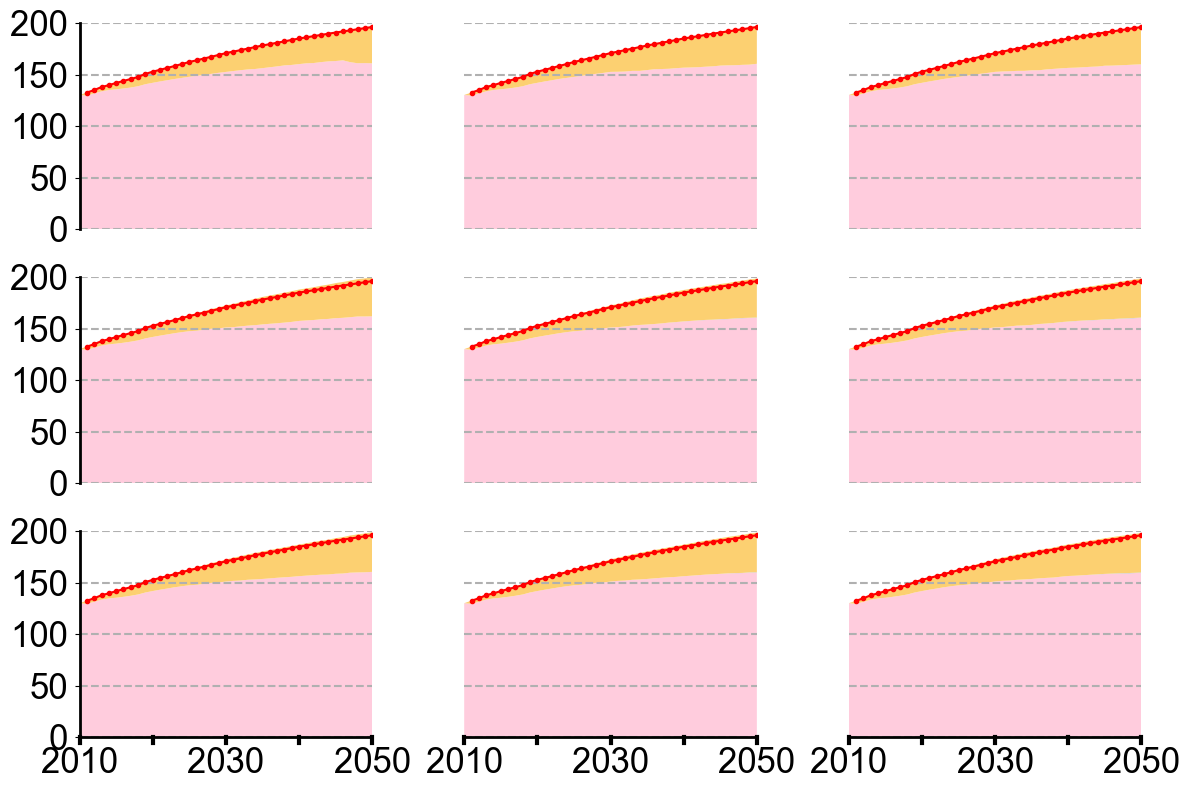

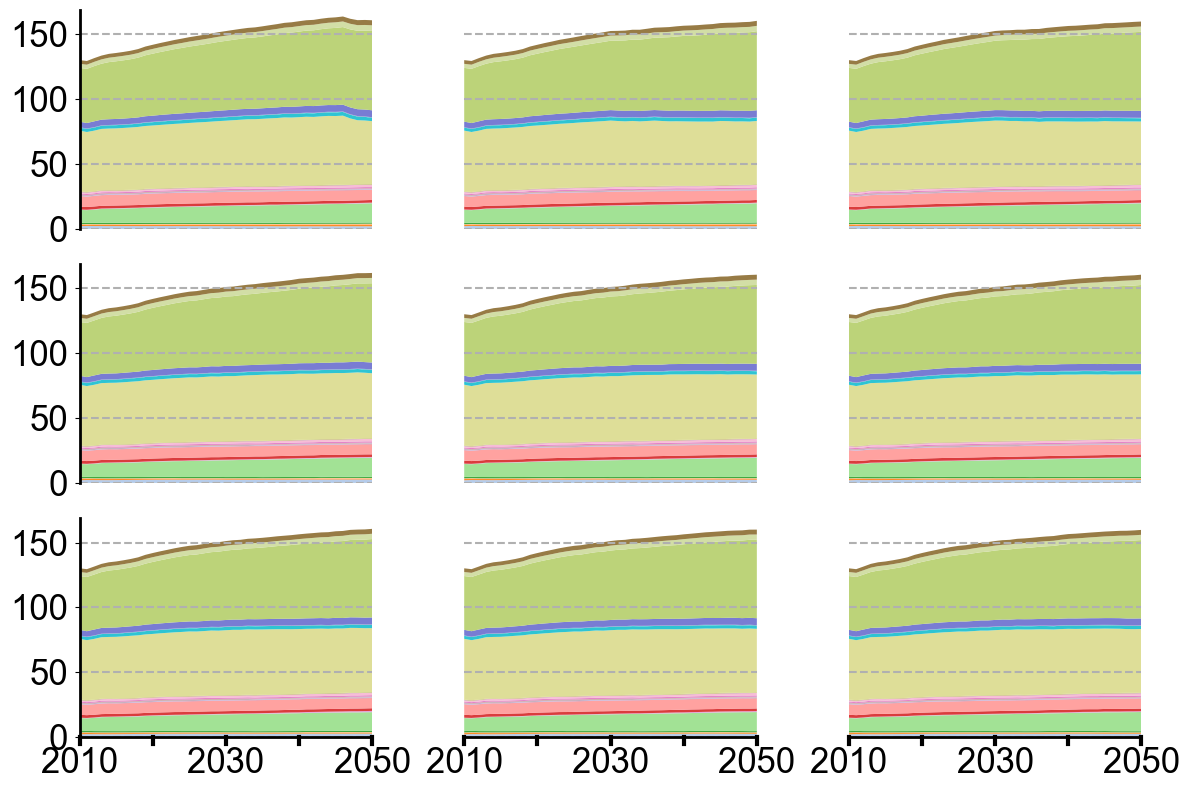

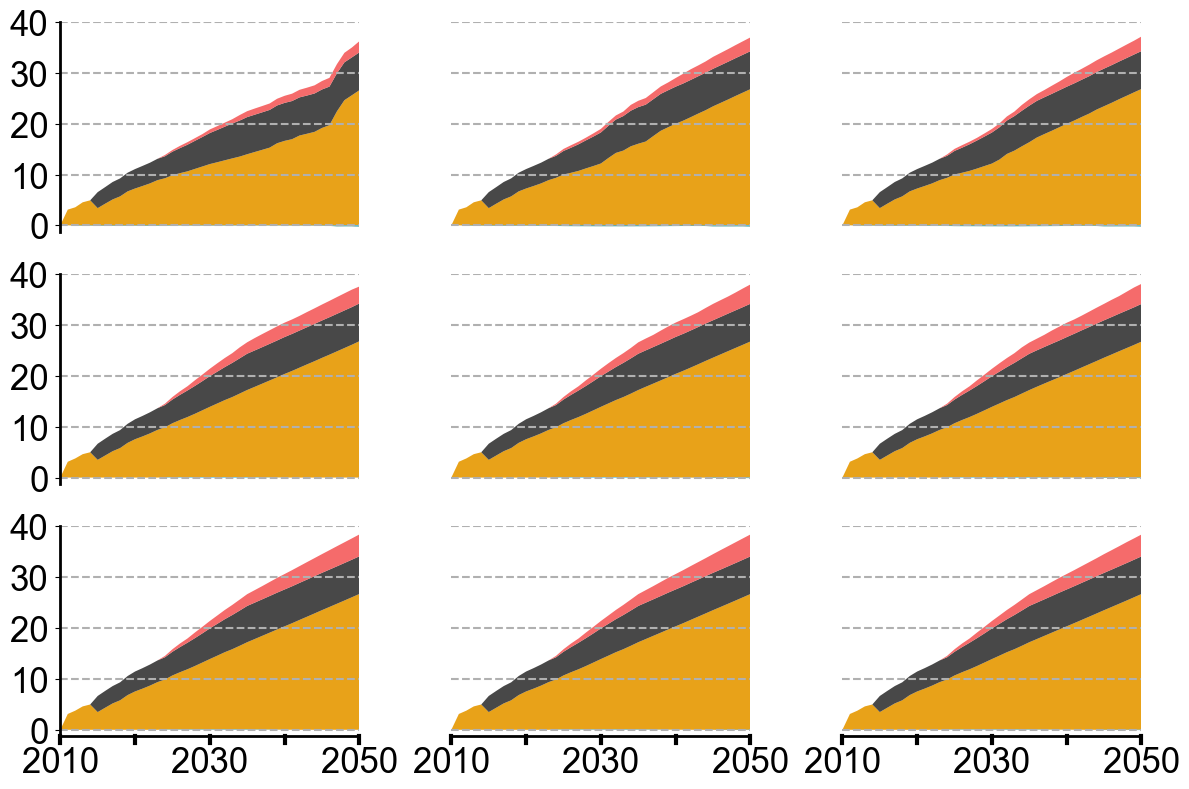

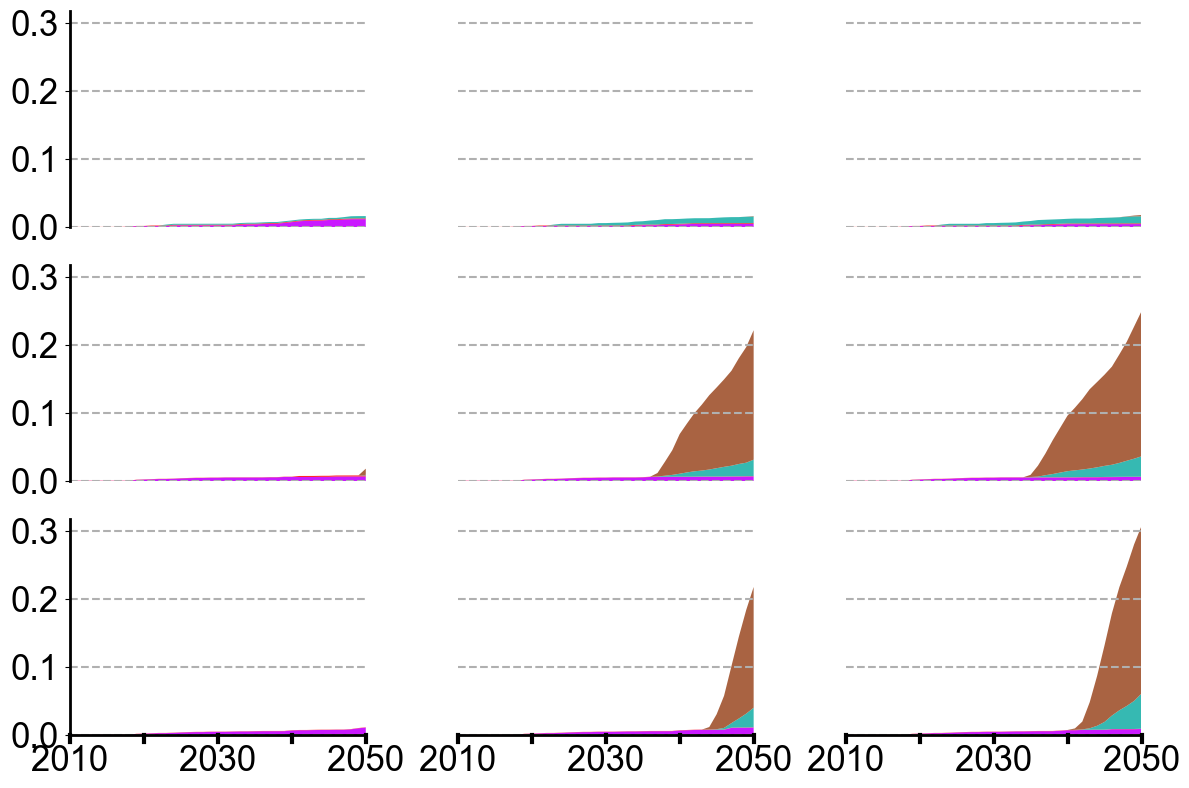

In [77]:
import numpy as np
import sys
import os
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from tools.data_helper import *
from tools.plot_helper import *
from tools.parameters import *

plt.rcParams['font.family'] = 'Arial'

# 获取到文件的绝对路径，并将其父目录添加到 sys.path
sys.path.append(os.path.abspath('../../../luto'))

# 导入 settings.py
import settings

csv_name, value_column_name, filter_column_name = "quantity_production_kt_separate", 'Production (tonnes, KL)', 'Landuse Type'
demand_dict = get_dict_data(input_files, csv_name, value_column_name, filter_column_name)
demand_ag_group_dict,legend_colors = get_colors(demand_dict, 'tools/land use colors.xlsx', sheet_name='lu')

Objective_demand_dict = get_dict_sum_data(input_files, "quantity_comparison", 'Demand (tonnes, KL)', 'Objectives')
# Product_demand_dict = get_dict_sum_data(input_files, "quantity_production_kt_separate", 'Production (tonnes, KL)', 'Production')
# point_dict = concatenate_dicts_by_year([Objective_demand_dict, Product_demand_dict])
point_dict = Objective_demand_dict
point_colors = ['red']
y_range, y_ticks = calculate_y_axis_range(demand_dict)

output_png = '../output/08_food.png'
plot_Combination_figures(demand_ag_group_dict, output_png, input_files, plot_stacked_area_and_line, legend_colors,point_dict=point_dict,point_colors=point_colors,
                            n_rows=3, n_cols=3, font_size=font_size, x_range=(2010, 2050), y_range=y_range,
                             x_ticks=20, y_ticks=y_ticks,
                             legend_position=(0.5, -0.25), show_legend='last', legend_n_rows=7)

csv_name, value_column_name, filter_column_name = "quantity_production_kt_separate", 'Production (tonnes, KL)', 'Landuse'
food_ag_dict = get_dict_data(input_files, csv_name, value_column_name, filter_column_name,['Landuse subtype'],['Agricultural Landuse'])
# food_ag_group_dict = aggregate_by_mapping(food_ag_dict, 'tools/land use group.xlsx', 'desc', 'ag')
food_ag_dict,legend_colors = get_colors(food_ag_dict, 'tools/land use colors.xlsx', sheet_name='ag')
output_png = '../output/09_food_ag'
y_range, y_ticks = calculate_y_axis_range(food_ag_dict,4)
plot_Combination_figures(food_ag_dict, output_png, input_files, plot_stacked_area, legend_colors,
                            n_rows=3, n_cols=3, font_size=font_size, x_range=(2010, 2050), y_range=y_range,
                             x_ticks=20, y_ticks=y_ticks,
                             legend_position=(0.5, -0.25), show_legend='last', legend_n_rows=2)

csv_name, value_column_name, filter_column_name = "quantity_production_kt_separate", 'Production (tonnes, KL)', 'Landuse subtype'
food_am_dict = get_dict_data(input_files, csv_name, value_column_name, filter_column_name)
food_am_dict,legend_colors = get_colors(food_am_dict, 'tools/land use colors.xlsx', sheet_name='am')
output_png = '../output/09_food_am_group'
y_range, y_ticks = calculate_y_axis_range(food_am_dict,4)
plot_Combination_figures(food_am_dict, output_png, input_files, plot_stacked_area, legend_colors,
                            n_rows=3, n_cols=3, font_size=font_size, x_range=(2010, 2050), y_range=y_range,
                             x_ticks=20, y_ticks=y_ticks,
                             legend_position=(0.5, -0.25), show_legend='last', legend_n_rows=2)

csv_name, value_column_name, filter_column_name = "quantity_production_kt_separate", 'Production (tonnes, KL)', 'Landuse'
food_non_ag_dict = get_dict_data(input_files, csv_name, value_column_name, filter_column_name)
food_non_ag_dict,legend_colors = get_colors(food_non_ag_dict, 'tools/land use colors.xlsx', sheet_name='non_ag')
output_png = '../output/09_food_non_ag_group'
y_range, y_ticks = calculate_y_axis_range(food_non_ag_dict)
plot_Combination_figures(food_non_ag_dict, output_png, input_files, plot_stacked_area, legend_colors,
                            n_rows=3, n_cols=3, font_size=font_size, x_range=(2010, 2050), y_range=y_range,
                             x_ticks=20, y_ticks=y_ticks,
                             legend_position=(0.5, -0.25), show_legend='last', legend_n_rows=2)


In [84]:
group_dict = {key: df.assign(sum=df.sum(axis=1)) for key, df in demand_ag_group_dict.items()}
substring = "*"
target_column = '*' # next(iter(group_dict.values())).columns[0]
year_filter = 2050

filtered_dict = filter_dfs_by_substring(group_dict, substring)

# 找出全局最大值和最小值
global_result = find_global_min_max(filtered_dict, target_column, year_filter)
result_result = add_value_label_column(global_result, "%")
result_result


,Statistic,Value Label,Column,Value,Index,Source
0,Min,"159.73 % (HighGHG, HighBIO)",Agricultural land-use,159.73,2050,Run_9_GHG_high_BIO_high
1,Max,"161.92 % (LowGHG, ModerateBIO)",Agricultural land-use,161.92,2050,Run_2_GHG_low_BIO_medium
2,Min,"0.01 % (LowGHG, HighBIO)",Non-agricultural land-use,0.01,2050,Run_3_GHG_low_BIO_high
3,Max,"0.31 % (HighGHG, HighBIO)",Non-agricultural land-use,0.31,2050,Run_9_GHG_high_BIO_high
4,Min,"35.94 % (LowGHG, LowBIO)",Agricultural management,35.94,2050,Run_1_GHG_low_BIO_low
5,Max,"38.43 % (LowGHG, HighBIO)",Agricultural management,38.43,2050,Run_3_GHG_low_BIO_high
6,Min,"196.78 % (HighGHG, LowBIO)",sum,196.78,2050,Run_7_GHG_high_BIO_low
7,Max,"199.52 % (LowGHG, ModerateBIO)",sum,199.52,2050,Run_2_GHG_low_BIO_medium


In [85]:
for key,df in demand_ag_group_dict.items():
    df['sum'] = df.sum(axis=1)
    df['percentage'] = df['Agricultural management'] / df['sum'] * 100
    print(f"{key}: {df.iloc[-1, -1]:.2f}%")

{'Run_1_GHG_low_BIO_low':       Agricultural land-use  Non-agricultural land-use  Agricultural management
 Year                                                                           
 2010               130.1281                     0.0000                   0.0000
 2011               129.4824                     0.0003                   3.0930
 2012               131.6751                     0.0003                   3.4827
 2013               133.6351                     0.0003                   4.4376
 2014               134.9504                     0.0003                   4.8450
 2015               135.6441                     0.0003                   6.4301
 2016               136.4411                     0.0003                   7.4163
 2017               137.3738                     0.0003                   8.4209
 2018               138.6479                     0.0009                   9.1301
 2019               140.6065                     0.0017                  10.2565
 20

In [79]:
35.94/196.73

0.1826869313271997

In [80]:
group_dict['Run_1_GHG_low_BIO_low'].columns

Index(['Agricultural land-use', 'Non-agricultural land-use', 'Agricultural management', 'sum'], dtype='object')

In [81]:
def extract_land_use_stats(result_file, filter_str=None, year=2050):
    """
    从Excel文件中提取每种土地利用类型在2050年的最大值和最小值，并找到对应的工作表名称。
    额外计算一级列名是2050，二级列名是'Area×Distance'的最大值和最小值。

    参数:
    result_file (str): Excel文件路径。
    filter_str (str, optional): 过滤包含此字符串的工作表。如果未提供，则比较全部工作表。

    返回:
    pd.DataFrame: 包含每种土地利用类型最大值和最小值及其对应工作表名称的DataFrame。
    """
    # 读取Excel文件中的所有工作表
    all_sheets = pd.read_excel(result_file, sheet_name=None, header=[0, 1])

    # 存储结果的列表
    results = []

    # 遍历每个工作表
    for sheet_name, df in all_sheets.items():
        # 如果提供了过滤字符串并且当前工作表名称不包含该字符串，则跳过该工作表
        if filter_str and filter_str not in sheet_name:
            continue

        # 确保列索引是MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            # 过滤出2050年的数据
            year_2050_cols = [col for col in df.columns if col[0] == year]
            if year_2050_cols:
                df_2050 = df.loc[:, year_2050_cols]
                # 获取土地利用类型
                land_use_column = df[('Year', 'Metric')]
                df_2050 = df_2050.copy()
                df_2050['Land Use'] = land_use_column

                # 对于每种土地利用类型，找到最大值和最小值
                for land_use in df_2050['Land Use'].unique():
                    df_land_use = df_2050[df_2050['Land Use'] == land_use]

                    # 仅选择数值列进行计算
                    numeric_cols = df_land_use.select_dtypes(include='number')

                    max_value = numeric_cols.max().max()
                    min_value = numeric_cols.min().min()

                    # 计算 'Area×Distance' 的最大值和最小值
                    area_distance_col = (year, 'Distance (km)')
                    if area_distance_col in df_land_use.columns:
                        max_area_distance = df_land_use[area_distance_col].max()
                        min_area_distance = df_land_use[area_distance_col].min()
                    else:
                        max_area_distance = None
                        min_area_distance = None

                    # 将结果添加到列表中
                    results.append({
                        'Land Use': land_use,
                        'Max Value': max_value,
                        'Max Sheet Name': sheet_name,
                        'Min Value': min_value,
                        'Min Sheet Name': sheet_name,
                        'Max Distance': max_area_distance,
                        'Min Distance': min_area_distance
                    })

    # 将结果转换为DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [82]:
result_file = "../output/12_land_use_movement_all.xlsx"
filter_str = None
results_df = extract_land_use_stats(result_file, filter_str,2050)
mask = (
    (results_df['Land Use'] == 'Beef - modified land')
    # & (results_df['Max Sheet Name'].str.contains('BIO_High'))
)
filtered = results_df[mask]
filtered

,Land Use,Max Value,Max Sheet Name,Min Value,Min Sheet Name,Max Distance,Min Distance
2,Beef - modified land,167.3260,Run_1_GHG_low_BIO_low,0.3011,Run_1_GHG_low_BIO_low,167.3260,167.3260
31,Beef - modified land,161.7650,Run_4_GHG_medium_BIO_low,0.2795,Run_4_GHG_medium_BIO_low,161.7650,161.7650
60,Beef - modified land,163.9910,Run_7_GHG_high_BIO_low,0.2748,Run_7_GHG_high_BIO_low,163.9910,163.9910
89,Beef - modified land,306.7700,Run_2_GHG_low_BIO_medium,0.2048,Run_2_GHG_low_BIO_medium,37.5070,37.5070
118,Beef - modified land,287.4800,Run_5_GHG_medium_BIO_medium,0.1658,Run_5_GHG_medium_BIO_medium,107.4070,107.4070
147,Beef - modified land,286.7000,Run_8_GHG_high_BIO_medium,0.1588,Run_8_GHG_high_BIO_medium,120.8070,120.8070
176,Beef - modified land,434.9880,Run_3_GHG_low_BIO_high,0.0888,Run_3_GHG_low_BIO_high,434.9880,434.9880
205,Beef - modified land,510.7870,Run_6_GHG_medium_BIO_high,0.0729,Run_6_GHG_medium_BIO_high,510.7870,510.7870
234,Beef - modified land,529.9450,Run_9_GHG_high_BIO_high,0.0667,Run_9_GHG_high_BIO_high,529.9450,529.9450
